In [274]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.linalg as la

In [595]:
#Constants
M = 100
R= 10
T=2
N=1000
sigma= 1/4.1 #1/5
r= 0.02
c=1
K_eur=10
H_eur=0
K_but = 1
H_but = 3
K_bin = 1
H_bin = 3

In [270]:
#Practical function
def tridiag(lower, diag, upper, size):
    A=np.diag(lower, -1) + np.diag(diag) + np.diag(upper, 1)
    return A

### Initial Conditions function

In [153]:
def european_put(x):
    europe=np.array(K_eur-x)
    europe[int((K_eur*M)/R):]=0
    return europe

def butterfly(x):
    term1=np.array(x-K_but) #First term
    for i in range(len(term1)):
        term1[i] = max(term1[i], 0)
    term2=np.array(x-(K_but+H_but)) #Second term
    for i in range(len(term2)):
        term2[i] = max(term2[i], 0)
    term3=np.array(x-(K_but+2*H_but)) #Third term
    for i in range(len(term3)):
        term3[i] = max(term3[i], 0)
    butterfly=term1-2*term2+term3
    return butterfly

def binary(x, strike_K, strike_H, R, M):
    arr=np.ones(len(x))
    indices=np.where(x-strike_K<0)
    np.put(arr, indices, 0)
    return arr

#### Boundary conditions

In [396]:
def boundary_0(t=None, u_0=K_eur, x=None):  
    return u_0*np.exp(-c*t)

def boundary_R_eur(R, x=None, t=None):
    return max((K_eur-R), 0)

def boundary_R_but(R, x=None, t=None):
    butterfly=max(R-K_but, 0) - 2*max((R-(K_but+H_but)), 0) + max((R-(K_but+2*H_but)), 0)
    return butterfly

def boundary_R_bin(R, x=None, t=None):
    if (R-K_bin)<0:
        return 0
    else:
        return 1

### Analytic initial and boundary conditions

In [487]:
def an_initial(x):
    return x**2

def an_boundary_0(t=None, u_0=K_eur, x=None):
    return t

def an_boundary_R(R, x=None, t=None):
    return R**2 + t

#### Analytic RHS

In [206]:
def RHS_analytic(x,t):
    tt, xx = np.meshgrid(t, x)
    ones = np.ones((len(x), len(t)))
    return ones - sigma**2 * xx**2  - 2*r*xx**2 + c*(tt + xx**2)

In [378]:
def plot_solution(U, angle=-30, title="Title"):
    x_len = len(U[:,])
    t_len = len(U[0])
    
    x=np.linspace(0, R, x_len) 
    t=np.linspace(0, T, t_len)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), subplot_kw={"projection": "3d"})
    tt, xx = np.meshgrid(t, x)
    ax.plot_surface(tt, xx, U, cmap=cm.coolwarm)
    ax.view_init(azim=angle)              # Rotate the figure
    ax.set_title(title)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    fig.tight_layout()

### Forward Euler

In [547]:
def forward_euler(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t))) ):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+1, N+1))       
    x=np.linspace(0, R, M+1)    #Remember to add stability condition with positive coefficient in tridiag
    t=np.linspace(0, T, N+1)      #Probably necessary to have many more timesteps and spacesteps for conv
    
    U[:, 0]=initial_func(x) #Initial and boundary functions
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    U[-1,:]=BCR(R, x=x, t=t)
    
    beta_neg1 = k*sigma**2*m**2/2 - k*r*m/2
    beta_0 = 1-k*sigma**2*m**2 - k*c
    beta_1 = k*sigma**2*m**2/2 + k*r*m/2
    
    F = RHS_func(x,t)[1:-1,:]
    G=np.zeros((M-1, N+1))
    
    G[0] = U[0, :]*beta_neg1[1] #Boundary conditions
    G[-1] = U[-1,:]*beta_1[-2]
    
    
    A=tridiag(beta_neg1[2:-1], beta_0[1:-1] ,beta_1[1:-2], M-1)
    
    CFL=min(np.diag(A))
    
    for n in range(N):
        U[1:-1, n+1]=A.dot(U[1:-1, n]) + G[:,n] + k*F[:,n]
    
    return U, CFL

### Backward Euler

In [525]:
def backward_euler(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t)))):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+1,N+1))
    x=np.linspace(0, R, M+1)        
    t=np.linspace(0, T, N+1)
    
    U[:, 0]=initial_func(x)  
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    U[-1,:]=BCR(R, x=x, t=t)
    
    #n + 1 - coefficients
    beta_neg1 = k*sigma**2*m**2/2 - k*r*m/2
    alpha_0 = 1+k*sigma**2*m**2 + k*c
    beta_1 = k*sigma**2*m**2/2 + k*r*m/2
    
    A=tridiag(-beta_neg1[2:-1], alpha_0[1:-1], -beta_1[1:-2], M-1)
    G=np.zeros((M-1, N+1))
    
    G[0] = U[0, :]*beta_neg1[1]  #Boundary conditions
    G[-1] = U[-1,:]*beta_1[-2]
    
    F = RHS_func(x,t)[1:-1,:]
    
    CFL=np.diag(A)
    
    for n in range(N):
        U[1:-1, n+1]=la.solve(A, U[1:-1, n]+G[:,n+1] + k*F[:,n+1])
        
    return U, CFL

### Crank-Nicolson

In [545]:
def crank_nicholson(R, M, T, N, sigma, r, c, K, H, BC0, BCR, initial_func, 
                  RHS_func = lambda x, t: np.zeros((len(x), len(t)))):
    h=R/M
    k=T/N
    m = np.arange(0, M+1, 1)
    
    U=np.zeros((M+1,N+1))
    x=np.linspace(0, R, M+1)         #How to choose M?
    t=np.linspace(0, T, N+1)
    
    U[:, 0]=initial_func(x)
    U[0, :]=BC0(t=t, x=x, u_0=initial_func(x)[0])
    U[-1,:]=BCR(R, x=x, t=t)
    
    #n + 1 - coefficients
    beta_neg1_np1 = k*sigma**2*m**2/4 - k*r*m/4
    alpha_0_np1 = 1+k*sigma**2*m**2/2 + k*c/2
    beta_1_np1 = k*sigma**2*m**2/4 + k*r*m/4
    
    #n - coefficients
    beta_neg1_n = k*sigma**2*m**2/4 - k*r*m/4
    beta_0_n = 1-k*sigma**2*m**2 /2- k*c/2
    beta_1_n = k*sigma**2*m**2/4 + k*r*m/4
    
    #Matrices
    A=tridiag(-beta_neg1_np1[2:-1], alpha_0_np1[1:-1], -beta_1_np1[1:-2],  M-1)
    B=tridiag(beta_neg1_n[2:-1], beta_0_n[1:-1], beta_1_n[1:-2],  M-1)
    
    #Boundary conditions
    G=np.zeros((M-1, N))
    G[0] = U[0, :-1]*beta_neg1_n[1] + U[0, 1:]*beta_neg1_np1[1]
    G[-1] = U[-1,:-1]*beta_neg1_n[-2] + U[-1, 1:]*beta_neg1_np1[-2]
    
    #RHS
    F = RHS_func(x,t)[1:-1,:]
    
    #Check CFL
    CFL=min(np.diag(A))
    
    
    for n in range(N):
        U[1:-1, n+1]=la.solve(A, np.dot(B, U[1:-1, n])+G[:,n] + k*(F[:,n] + F[:,n+1])/2 )
    
    return U, CFL

### Problem 1 e)

We first want to check what happens when the CFL condition $1- k \sigma^2 (M-1)^2 - kc \geq 0$ doesn't hold. For example, we can let $\sigma=1/4$ be such that the left hand side is negative.

In [ ]:
We can for

We now define a nice analytic function $v(x,t)=t + x^2$ and find an appropriate right hand side in the linear BS-equation. We see that 
$$
v_t - \frac12 \sigma^2 x^2 v_{xx} - r x v_x + c v = \partial_t(t+x^2) - \frac12 \sigma^2 x^2 \partial_{xx}(t + x^2) - rx \partial_x(t + x^2) + c(t+x^2) = \underbrace{ 1 - \sigma^2 x^2 - 2rx^2 + c(t+x^2)}_{\text{RHS}}.
$$

We now seek to test our scheme on this equation, and compare it to the analytical function to check the convergence as function of $h$.

In [514]:
x=np.linspace(0, R, M+1)    #Remember to add stability condition with positive coefficient in tridiag
t=np.linspace(0, T, N+1)

tt, xx = np.meshgrid(t,x)

def u_exact(t, x):
    return t + x**2
u_exact = u_exact(tt,xx)

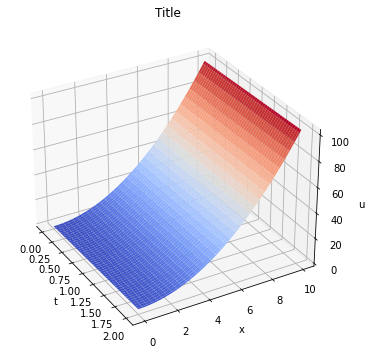

In [527]:
plot_solution(u_exact)

-0.16809161213563373


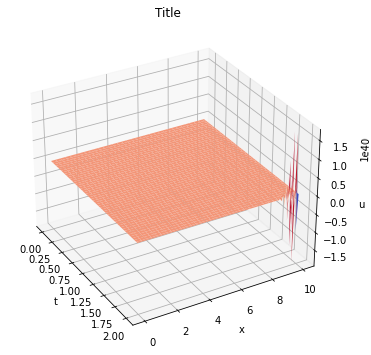

In [596]:
u_an, CFL = forward_euler(R, M, T, N, sigma, r, c, K_eur, H_eur, an_boundary_0, an_boundary_R, 
                       an_initial, RHS_func=RHS_analytic)
plot_solution(u_an)
print(CFL)

### Error as function of time

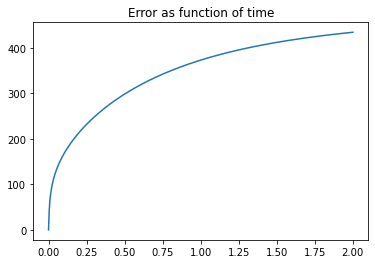

In [466]:
def error_func(u_numeric, u_analytic):
    error= np.zeros(len(u_numeric[0]))
    for i in range(len(error)):
        error[i] = la.norm(u_numeric[:,i] - u_analytic[:,i] ) #Assume 2-norm
    return error

error_forward_euler = error_func(u_exact, u_an)
plt.title("Error as function of time")
plt.plot(t, error_forward_euler)
plt.show()